# Lab1 - Assignment

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# 1. Load CIFAR10
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = np.array(('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


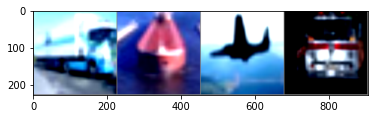

tensor([9, 8, 0, 9]) ['truck' 'ship' 'plane' 'truck']


In [3]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

toshow = torchvision.utils.make_grid(images)
toshow = toshow / 2 + 0.5     # unnormalize
npimg = toshow.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
print(labels, classes[labels])

In [4]:
# 2. Load AlexNet
# https://github.com/pytorch/vision/releases
# The newest version isa 0.8.2 and load empty model
model = torch.hub.load('pytorch/vision:v0.8.2', 'alexnet', pretrained=False)
print(model.eval())

# https://analyticsindiamag.com/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/
#Updating the second classifier
# AlexNet_model.classifier[4] = nn.Linear(4096,1024)
#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
model.classifier[6] = nn.Linear(4096,10)
print(model.eval())

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.8.2
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)

In [5]:
# move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:3


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [7]:
losses = []
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training of AlexNet')
# save looses
with open("losses.txt", "wb") as f:   #Pickling
    pickle.dump(losses, f)
# save model
torch.save(model, "alextrain.model")

[1,  2000] loss: 2.302
[1,  4000] loss: 2.301
[1,  6000] loss: 2.298
[1,  8000] loss: 2.277
[1, 10000] loss: 2.053
[1, 12000] loss: 1.892
[2,  2000] loss: 1.762
[2,  4000] loss: 1.685
[2,  6000] loss: 1.637
[2,  8000] loss: 1.601
[2, 10000] loss: 1.551
[2, 12000] loss: 1.518
[3,  2000] loss: 1.473
[3,  4000] loss: 1.436
[3,  6000] loss: 1.406
[3,  8000] loss: 1.387
[3, 10000] loss: 1.341
[3, 12000] loss: 1.320
[4,  2000] loss: 1.272
[4,  4000] loss: 1.234
[4,  6000] loss: 1.233
[4,  8000] loss: 1.211
[4, 10000] loss: 1.188
[4, 12000] loss: 1.167
[5,  2000] loss: 1.092
[5,  4000] loss: 1.088
[5,  6000] loss: 1.058
[5,  8000] loss: 1.052
[5, 10000] loss: 1.045
[5, 12000] loss: 1.019
[6,  2000] loss: 0.935
[6,  4000] loss: 0.942
[6,  6000] loss: 0.908
[6,  8000] loss: 0.880
[6, 10000] loss: 0.899
[6, 12000] loss: 0.883
[7,  2000] loss: 0.778
[7,  4000] loss: 0.793
[7,  6000] loss: 0.775
[7,  8000] loss: 0.771
[7, 10000] loss: 0.751
[7, 12000] loss: 0.757
[8,  2000] loss: 0.646
[8,  4000] 

In [8]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75 %


In [9]:
#Testing classification accuracy for individual classes.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 80 %
Accuracy of   car : 86 %
Accuracy of  bird : 72 %
Accuracy of   cat : 55 %
Accuracy of  deer : 67 %
Accuracy of   dog : 66 %
Accuracy of  frog : 80 %
Accuracy of horse : 81 %
Accuracy of  ship : 84 %
Accuracy of truck : 81 %


In [10]:
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  75.74


# Multiple GPU

In [12]:
# save model
torch.save(model, "alextrain.model")

In [11]:
# import torch
# import torchvision
# import torchvision.transforms as transforms

# import matplotlib.pyplot as plt
# import numpy as np

# import torch.optim as optim
# import torch.nn as nn

# # 1. Load dataset
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# # rand_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# classes = np.array(('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))

# # 2. Load AlexNet
# import torch
# import torch.nn as nn
# model = torch.hub.load('pytorch/vision:v0.8.2', 'alexnet', pretrained=False)
# model.classifier[6] = nn.Linear(4096,10)

# #Loss
# criterion = nn.CrossEntropyLoss()
# #Optimizer(SGD)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # # https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#   model = nn.DataParallel(model, device_ids=[0,1,2])

# model.to(device)
# for epoch in range(10):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # print("Outside: input size", inputs.size())
#         # 1 GPUs Outside: input size torch.Size([4, 3, 224, 224])
#         # 2 GPUs Outside: input size torch.Size([4, 3, 224, 224])
#         # 3 GPUs Outside: input size torch.Size([4, 3, 224, 224])
#         # output_size torch.Size([4, 10])
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         output = model(inputs)
#         # print("output_size", output.size())
#         loss = criterion(output, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 10 == 0:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training of AlexNet')